### 运行一次来获得cookie
- 注意填充自己的帐号密码

In [ ]:
import requests
import time
from selenium import webdriver

def get_pixiv_cookie(pixiv_id,pixiv_pw):
    driver = webdriver.Chrome()  # Optional argument, if not specified will search pat
    driver.get('https://accounts.pixiv.net/login');

    time.sleep(0.5)

    account = driver.find_element_by_css_selector('input[autocomplete="username"]')
    account.send_keys(pixiv_id)
    time.sleep(10)
    password = driver.find_element_by_css_selector('input[autocomplete="current-password"]')
    password.send_keys(pixiv_pw)

    time.sleep(1)

    password.submit()
    time.sleep(10)
    cookie=driver.get_cookies()
    driver.close()
    return cookie

f=open("account.txt")


p_id = f.readline().rstrip()
p_pw = f.readline().rstrip()

f.close()

cookies_list=get_pixiv_cookie(p_id,p_pw)

f=open("cookie.txt","w")
f.write(str(cookies_list))
f.close()

### 下面的直接运行可以就可以根据id爬图了

In [ ]:
import requests
import urllib.request
import urllib.parse
from bs4 import BeautifulSoup
from PIL import Image
import sys
import time
from selenium import webdriver
import json

- 从保存的文件获取cookie

In [ ]:
f=open("cookie.txt","r")
cookie_list=eval(f.readline())
f.close()

s = requests.Session()
for cookie in cookie_list:
    s.cookies.set(cookie['name'], cookie['value'])

- 获取预载信息

In [ ]:
pid='86685722'
delay=0.5

url="https://www.pixiv.net/artworks/"+pid
hder1={
    'User-Agent':'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/84.0.4147.135 Safari/537.36 Edg/84.0.522.63',
}
r=s.get(url,headers=hder1)

soup=BeautifulSoup(r.text, 'html.parser')
meta=soup.find('meta',id="meta-preload-data")# 格式化后可清晰看到这里是预载信息
js=json.loads(meta['content'])
# print(json.dumps(js,indent=2))

使用`print(soup.prettify())`打印输出之后,可以清楚的发现预载信息在一个叫`meta-preload-data`的`meta`中

之后将内容提取之后也格式化

这是json文件,使用`json.dumps(js,indent=2)`进行格式化输出

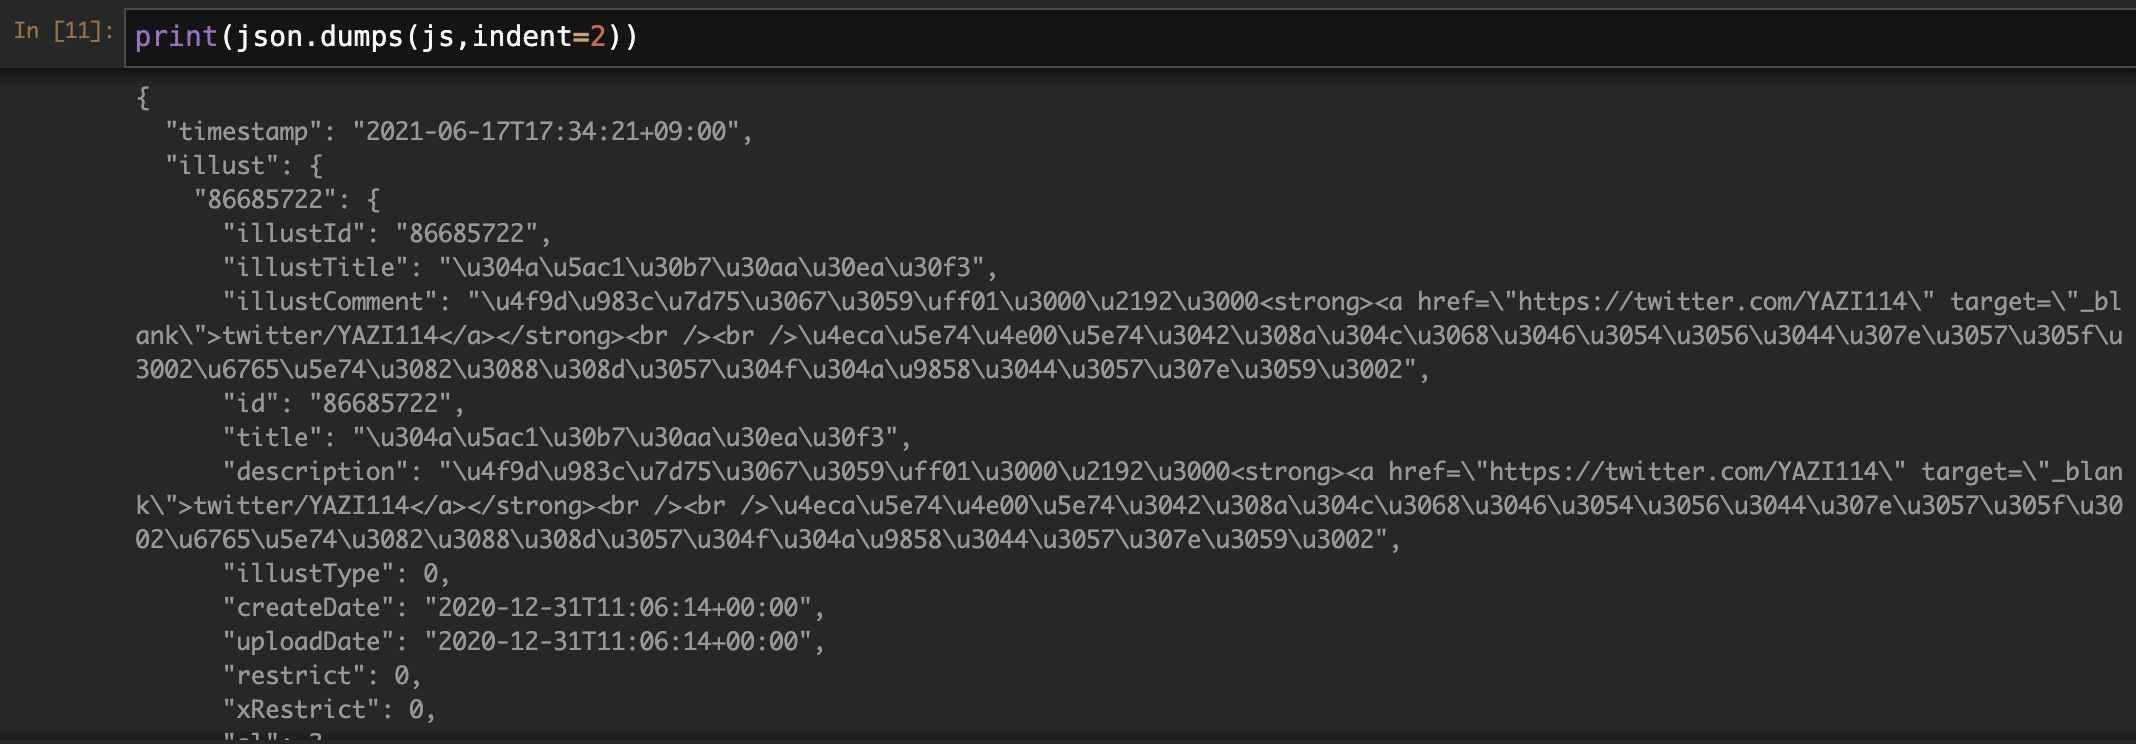

js本身是列表,通过列表的形式获取需要的信息,这里需要的主要是url和页数信息

- 获取图片

In [ ]:
def get_image(_url,_hder,_filename=None,_folder='img'):
    if _filename==None:
        img_path=urllib.parse.urlparse(_url).path
        _filename=img_path.split('/')[-1]#路径的最后一项是文件名
    
    f=open(_folder+'/'+_filename,"wb")
    re=requests.get(_url,headers=_hder)

    f.write(re.content)
    f.close()

hder2 = {
    'User-Agent':'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/84.0.4147.135 Safari/537.36 Edg/84.0.522.63',
    "referer":"https://www.pixiv.net/"
}

ori=js["illust"][pid]['urls']['original']
pagecount=js['illust'][pid]['pageCount']

for i in range(pagecount):
    url=ori.replace("p0","p"+str(i))
#     print(url)
    get_image(url,hder2)
    time.sleep(delay)

这里注意只有`pixiv.net`发出的原图请求`pximg.net`才会受理,这个需要在原图界面观察Network后筛选得到

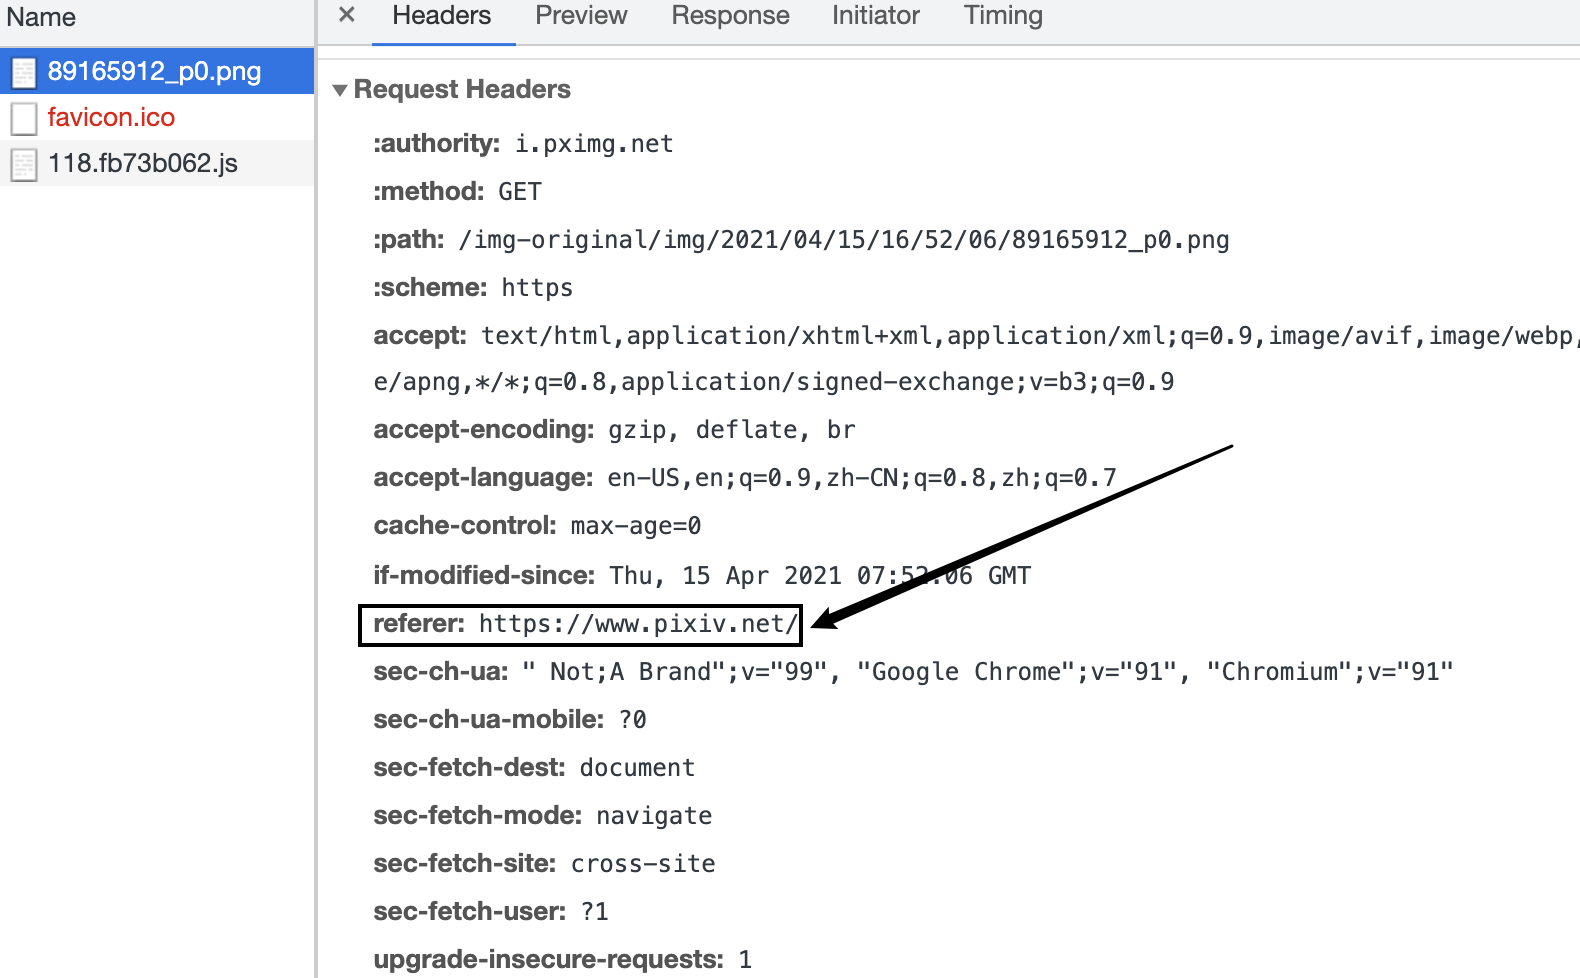

### 整合了以上代码

In [ ]:
import requests
import urllib.request
import urllib.parse
from bs4 import BeautifulSoup
from PIL import Image
import sys
import time
import json

def get_image(_url,_hder,_filename=None,_folder='img'):
    if _filename==None:
        img_path=urllib.parse.urlparse(_url).path
        _filename=img_path.split('/')[-1]#路径的最后一项是文件名
    
    f=open(_folder+'/'+_filename,"wb")
    re=requests.get(_url,headers=_hder)

    f.write(re.content)
    f.close()

def download_id(pid):
    f=open("cookie.txt","r")
    cookie_list=eval(f.readline())
    f.close()

    s = requests.Session()
    for cookie in cookie_list:
        s.cookies.set(cookie['name'], cookie['value'])
        
    if(type(pid)==int):
        pid=str(pid)
    
    delay=0.5

    url="https://www.pixiv.net/artworks/"+pid
    hder1={
        'User-Agent':'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/84.0.4147.135 Safari/537.36 Edg/84.0.522.63',
    }
    r=s.get(url,headers=hder1)

    soup=BeautifulSoup(r.text, 'html.parser')
    meta=soup.find('meta',id="meta-preload-data")
    js=json.loads(meta['content'])
    
    hder2 = {
        'User-Agent':'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/84.0.4147.135 Safari/537.36 Edg/84.0.522.63',
        "referer":"https://www.pixiv.net/"
    }

    ori=js["illust"][pid]['urls']['original']
    pagecount=js['illust'][pid]['pageCount']

    for i in range(pagecount):
        url=ori.replace("p0","p"+str(i))
        get_image(url,hder2)
        time.sleep(delay)

In [ ]:
download_id(90479236)